In [88]:
#@title Importar bibliotecas
import sys
import os
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical

In [89]:
#@title Configuración
sns.set(style="darkgrid")
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)

In [90]:
#@title Montar en drive drive
print("Montando en Google Drive")
drive.mount('/content/drive',force_remount=True)
print("Google Drive montado exitosamente en /content/drive/My Drive/")

Montando en Google Drive
Mounted at /content/drive
Google Drive montado exitosamente en /content/drive/My Drive/


In [91]:
#@title Cambiar directorio de trabajo
project_root = '/content/drive/My Drive/Colab Notebooks/cardiac-arrhytmia-detection'
if not os.path.exists(project_root):
  print(f"ERROR: La ruta especificada para la raíz del proyecto no existe: {project_root}")
else:
  os.chdir(project_root)
  print(f"Directorio de trabajo cambiado a: {os.getcwd()}")

Directorio de trabajo cambiado a: /content/drive/My Drive/Colab Notebooks/cardiac-arrhytmia-detection


In [92]:
#@title Cargar dataset
main_path = './data/'
try:
  normal_data = pd.read_csv(f'{main_path}ptbdb_normal.csv', header=None)
  abnormal_data = pd.read_csv(f'{main_path}ptbdb_abnormal.csv', header=None)
  patient_data = pd.read_csv(f'{main_path}patient_1.csv', header=None)

  print("Datos cargados exitosamente.")
  print(f"Tamaño del conjunto de datos normal: {normal_data.shape}")
  print(f"Tamaño del conjunto de datos abnormal: {abnormal_data.shape}")
  print(f"Tamaño del conjunto de datos de pacientes: {patient_data.shape}")

except FileNotFoundError as e:
  print(f"ERROR: No se encontraron los archivos CSV en la ruta especificada: {main_path}")
  print(f"Datos del error: {e}")

except Exception as e:
  print(f"ERROR: Ocurrió un error al cargar los datos: {e}")

Datos cargados exitosamente.
Tamaño del conjunto de datos normal: (4046, 188)
Tamaño del conjunto de datos abnormal: (10506, 188)
Tamaño del conjunto de datos de pacientes: (1, 188)


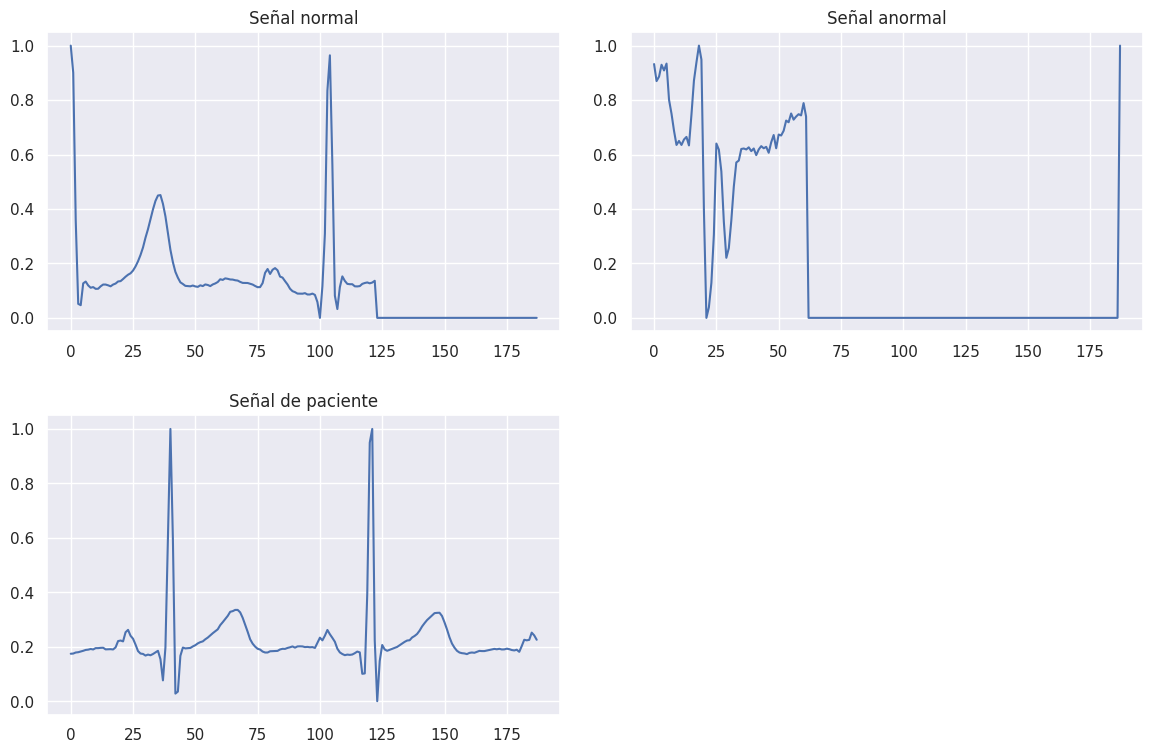

In [93]:
#@title Visualizar las señales
plt.subplot(2, 2, 1)
plt.plot(normal_data.iloc[0])
plt.title("Señal normal")

plt.subplot(2, 2, 2)
plt.plot(abnormal_data.iloc[0])
plt.title("Señal anormal")

plt.subplot(2, 2, 3)
plt.plot(patient_data.iloc[0])
plt.title("Señal de paciente")

plt.tight_layout(pad=2.0)
plt.show()

In [94]:
#@title Preparación de los datos y preprocesamiento

# Crear las etiquetas
normal_labels = np.zeros((normal_data.shape[0], 1)) # 0 para normal
abnormal_labels = np.ones((abnormal_data.shape[0], 1)) # 1 para abnormal
patient_labels = np.zeros((patient_data.shape[0], 1))

# Combinar los datos y las etiquetas
data = np.vstack((normal_data.values, abnormal_data.values))
labels = np.vstack((normal_labels, abnormal_labels))

ecg_data = np.vstack((data, patient_data.values))
ecg_labels = np.vstack((labels, patient_labels))

# Preprocesamiento de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
patient_scaled = scaler.fit_transform(patient_data)

# Codificar las etiquetas con One Hot Encoding
labels_one_hot = to_categorical(labels)
ecg_labels_one_hot = to_categorical(ecg_labels)
print(labels_one_hot.shape)
print(ecg_labels_one_hot.shape)

# Divir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(data_scaled, labels_one_hot, test_size=0.2, random_state=42)
print(f"""X_train shape: {X_train.shape}
X_val shape: {X_val.shape}
y_train shape: {y_train.shape}
y_val shape: {y_val.shape}""")

(14552, 2)
(14553, 2)
X_train shape: (11641, 188)
X_val shape: (2911, 188)
y_train shape: (11641, 2)
y_val shape: (2911, 2)


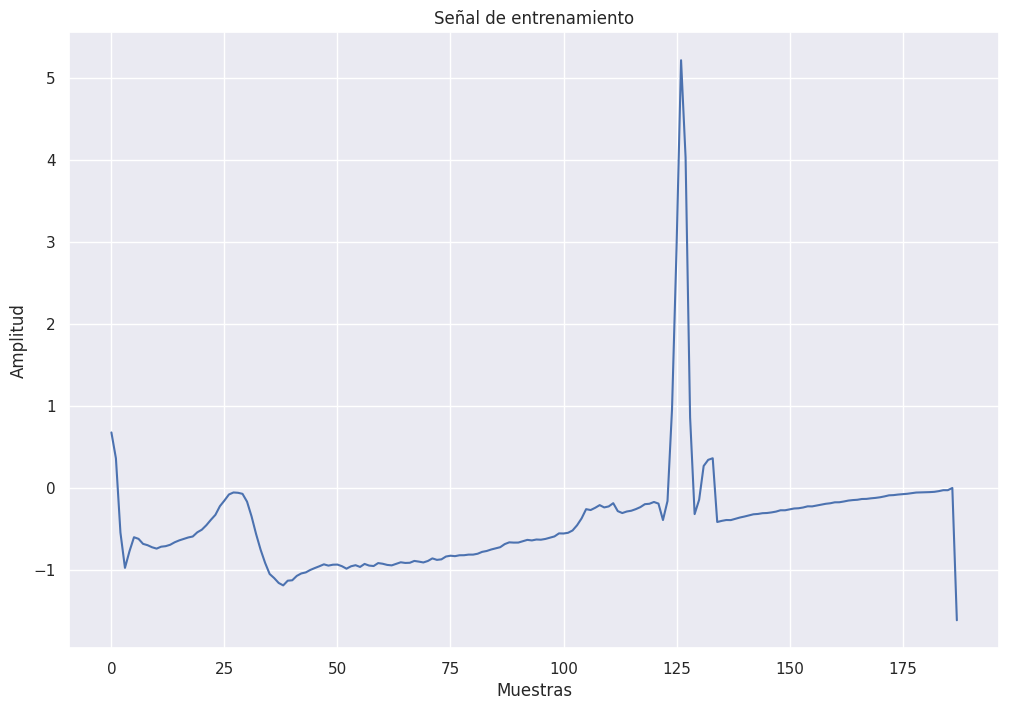

Clase: [1. 0.]


In [95]:
#@title Visualizar una de las señales de entrenamiento
plt.plot(X_train[10])
plt.title("Señal de entrenamiento")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.show()
print("Clase:",  y_train[10])

In [96]:
#@title Definir y entrenar el modelo

# Construir el modelo CNN utilizando Keras
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(10, activation='relu'),
    Dense(2, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [ModelCheckpoint(filepath='results/weights.weights.h5', save_weights_only=True, save_best_only=False), CSVLogger('results/training_log.csv')]

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5846 - loss: 0.6531 - val_accuracy: 0.8411 - val_loss: 0.3386
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9007 - loss: 0.2437 - val_accuracy: 0.9820 - val_loss: 0.0780
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9868 - loss: 0.0547 - val_accuracy: 0.9936 - val_loss: 0.0249
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9940 - val_loss: 0.0188
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9970 - loss: 0.0100 - val_accuracy: 0.9974 - val_loss: 0.0086
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9991 - val_loss: 0.0042
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9996 - val_

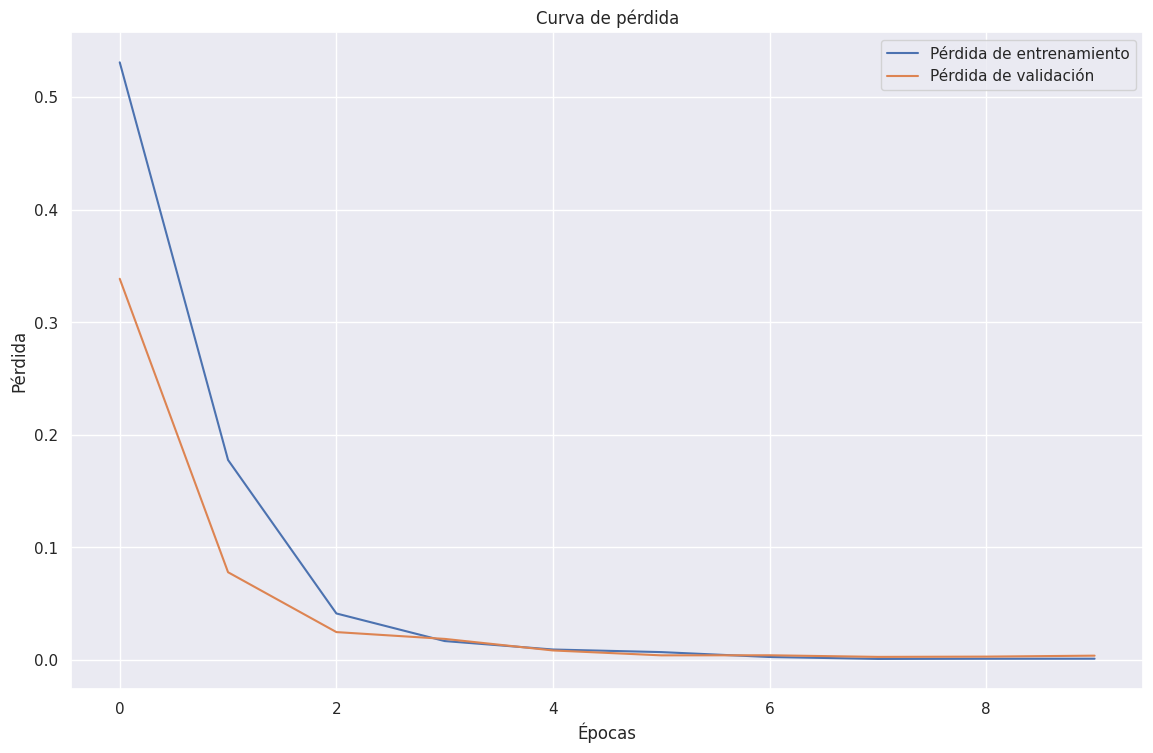

In [97]:
#@title Resultados de entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')

plt.legend()
plt.tight_layout(pad=2.0)
plt.savefig('results/loss_curve.png')
plt.show()

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


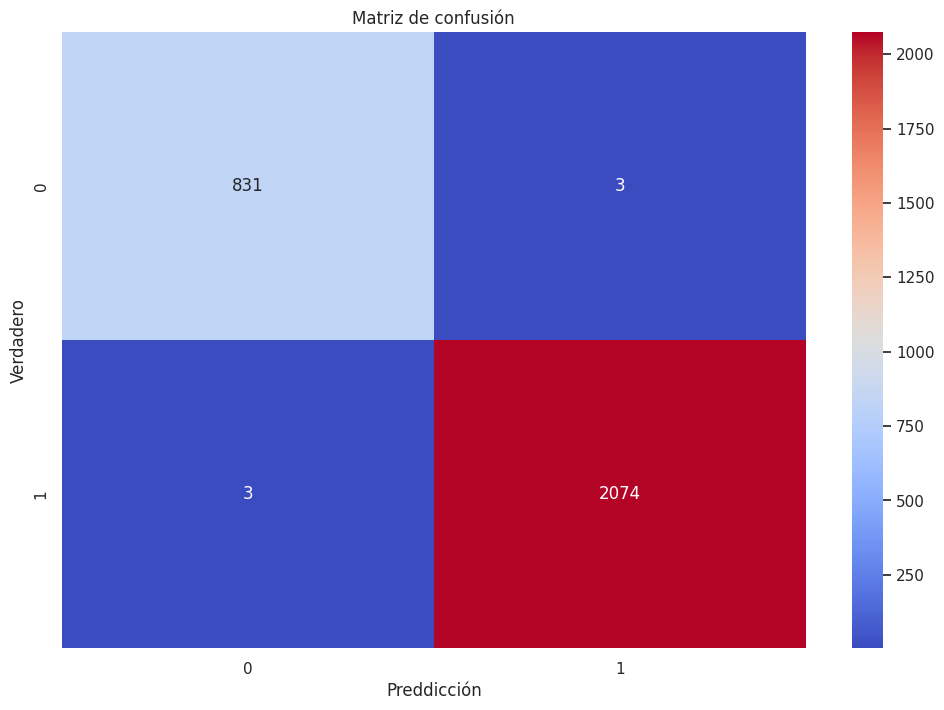

Precisión del modelo: 99.79%


In [98]:
#@title Evaluar el modelo

# Evaluar el modelo con el conjunto de prueba
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

# Mostrar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Preddicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.savefig('results/confusion_matrix.png')
plt.show()

# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

In [99]:
#@title Evaluar modelo con datos del paciente

# Predicción con datos del paciente
patient_predictions = model.predict(patient_scaled)

# Interpretar las predicciones
threshold = 0.8
patient_predicted_classes = (patient_predictions[:, 1] > threshold).astype(int)

# Mostrar los resultados
for i, pred in enumerate(patient_predicted_classes):
  label= "Normal" if pred == 0 else "Abnormal"
  print(f"El ECG del paciente es: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
El ECG del paciente es: Abnormal
